## Baseline Models

In [ ]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

dataframes = {}
for filename in uploaded:
    df = pd.read_csv(filename)
    dataframes[filename] = df
    print(f"{filename}: {df.shape}")


Saving dim_customers (1).csv to dim_customers (1).csv
Saving dim_dates (1).csv to dim_dates (1).csv
Saving dim_products (1).csv to dim_products (1).csv
Saving dim_promotions (1).csv to dim_promotions (1).csv
Saving fact_transactions_1 (1).csv to fact_transactions_1 (1).csv
Saving fact_transactions_2 (1).csv to fact_transactions_2 (1).csv
dim_customers (1).csv: (224805, 6)
dim_dates (1).csv: (2191, 9)
dim_products (1).csv: (38332, 8)
dim_promotions (1).csv: (318, 7)
fact_transactions_1 (1).csv: (900000, 6)
fact_transactions_2 (1).csv: (392973, 6)


In [ ]:
fact1 = dataframes['fact_transactions_1 (1).csv']
fact2 = dataframes['fact_transactions_2 (1).csv']
customers = dataframes['dim_customers (1).csv']
products = dataframes['dim_products (1).csv']
dates = dataframes['dim_dates (1).csv']
promotions = dataframes['dim_promotions (1).csv']

In [ ]:
# Step 1: Combine fact_transactions_1 and fact_transactions_2
fact_transactions = pd.concat([fact1, fact2], ignore_index=True)

In [ ]:
# Step 2: Merge necessary dimensions (left join to keep all transactions)
fact_enriched = (
    fact_transactions
    .merge(customers, on="Customer_ID", how="left")
    .merge(products, on="Product_ID", how="left")
    .merge(dates, on="Date_ID", how="left")
)

# Print columns after each merge to check for 'Price'
print("Columns after merging with customers:", fact_enriched.columns)

fact_enriched = fact_enriched.merge(products, on="Product_ID", how="left")
print("Columns after merging with products:", fact_enriched.columns)

fact_enriched = fact_enriched.merge(dates, on="Date_ID", how="left")
print("Columns after merging with dates:", fact_enriched.columns)

Columns after merging with customers: Index(['Transaction_ID', 'Date_ID', 'Customer_ID', 'Product_ID', 'Quantity',
       'Unit_Price', 'City', 'ST', 'Zip', 'Email_Subscriber', 'Loyalty_Tier',
       'SKU', 'Name', 'Brand', 'Category_1', 'Category_2', 'Category_3',
       'Launch_Date', 'Date', 'Day', 'ISO_Week', 'Month', 'Quarter', 'Year',
       'Day_of_Week', 'Is_US_Holiday'],
      dtype='object')
Columns after merging with products: Index(['Transaction_ID', 'Date_ID', 'Customer_ID', 'Product_ID', 'Quantity',
       'Unit_Price', 'City', 'ST', 'Zip', 'Email_Subscriber', 'Loyalty_Tier',
       'SKU_x', 'Name_x', 'Brand_x', 'Category_1_x', 'Category_2_x',
       'Category_3_x', 'Launch_Date_x', 'Date', 'Day', 'ISO_Week', 'Month',
       'Quarter', 'Year', 'Day_of_Week', 'Is_US_Holiday', 'SKU_y', 'Name_y',
       'Brand_y', 'Category_1_y', 'Category_2_y', 'Category_3_y',
       'Launch_Date_y'],
      dtype='object')
Columns after merging with dates: Index(['Transaction_ID', 'Date_ID'

In [ ]:
# Step 3: Select a subset of useful columns to reduce memory
# Update 'Price' to 'Unit_Price' in selected_columns
selected_columns = [
    'Transaction_ID', 'Customer_ID', 'Product_ID', 'Date_ID',
    'Quantity', 'Unit_Price', 'Age_Group', 'Gender', 'Region',
    'Category_1_x', 'Category_2_x', 'Brand_x', 'Launch_Date_x',  # Use _x suffixes
    'Date_x', 'Month_x', 'Day_of_Week_x'  # Use _x suffixes
]

fact_enriched = fact_enriched[[col for col in selected_columns if col in fact_enriched.columns]]

display(fact_enriched)

,Transaction_ID,Customer_ID,Product_ID,Date_ID,Quantity,Unit_Price,Category_1_x,Category_2_x,Brand_x,Launch_Date_x,Date_x,Month_x,Day_of_Week_x
0,1,110322,37052,1128,1,17.99,cars & trucks,"parts, electronics & accessories",arrma,2019-04-12,2021-02-01,2,monday
1,1,110322,36229,1128,1,17.99,cars & trucks,"parts, electronics & accessories",arrma,2018-10-03,2021-02-01,2,monday
2,1,110322,35909,1128,1,3.99,cars & trucks,"parts, electronics & accessories",arrma,2018-09-27,2021-02-01,2,monday
3,2,130093,8025,1128,1,99.99,airplanes,radio systems,realflight,2020-10-01,2021-02-01,2,monday
4,2,130093,5110,1128,1,39.99,radios,accessories,spektrum,2019-11-01,2021-02-01,2,monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292968,672141,224356,5310,2007,2,29.99,radios,aircraft,spektrum,2019-08-06,2023-06-30,6,friday
1292969,672142,223941,24181,2007,1,319.99,airplanes,by completion level,e-flite,2023-06-30,2023-06-30,6,friday
1292970,672143,224630,18500,2007,1,10.99,radios,accessories,hangar 9,NaN,2023-06-30,6,friday
1292971,672143,224630,5196,2007,3,13.99,radios,accessories,spektrum,2019-05-19,2023-06-30,6,friday


In [ ]:
# Step 4: Feature Engineering

user_features = (
    fact_enriched.groupby("Customer_ID")
    .agg(
        total_spend=pd.NamedAgg(column="Unit_Price", aggfunc="sum"),  # Change here
        avg_quantity=pd.NamedAgg(column="Quantity", aggfunc="mean"),
        num_transactions=pd.NamedAgg(column="Transaction_ID", aggfunc="count"),
        distinct_products=pd.NamedAgg(column="Product_ID", aggfunc="nunique")
    )
    .reset_index()
)

product_features = (
    fact_enriched.groupby("Product_ID")
    .agg(
        total_sales=pd.NamedAgg(column="Unit_Price", aggfunc="sum"),  # Change here
        avg_quantity_sold=pd.NamedAgg(column="Quantity", aggfunc="mean"),
        num_purchases=pd.NamedAgg(column="Transaction_ID", aggfunc="count"),
        distinct_buyers=pd.NamedAgg(column="Customer_ID", aggfunc="nunique")
    )
    .reset_index()
)
# Merge these into the enriched dataset for hybrid modeling
fact_final = (
    fact_enriched
    .merge(user_features, on="Customer_ID", how="left")
    .merge(product_features, on="Product_ID", how="left")
)

# Drop any unnecessary large columns to save memory
drop_cols = ['Full_Date']
fact_final.drop(columns=[col for col in drop_cols if col in fact_final.columns], inplace=True)

# Display the final dataframe using IPython.display.display
display(fact_final) # Changed this line

,Transaction_ID,Customer_ID,Product_ID,Date_ID,Quantity,Unit_Price,Category_1_x,Category_2_x,Brand_x,Launch_Date_x,...,Month_x,Day_of_Week_x,total_spend,avg_quantity,num_transactions,distinct_products,total_sales,avg_quantity_sold,num_purchases,distinct_buyers
0,1,110322,37052,1128,1,17.99,cars & trucks,"parts, electronics & accessories",arrma,2019-04-12,...,2,monday,1266.600,1.075000,40,39,3634.100,1.079208,202,197
1,1,110322,36229,1128,1,17.99,cars & trucks,"parts, electronics & accessories",arrma,2018-10-03,...,2,monday,1266.600,1.075000,40,39,9518.400,1.055028,527,492
2,1,110322,35909,1128,1,3.99,cars & trucks,"parts, electronics & accessories",arrma,2018-09-27,...,2,monday,1266.600,1.075000,40,39,850.130,1.164894,188,183
3,2,130093,8025,1128,1,99.99,airplanes,radio systems,realflight,2020-10-01,...,2,monday,1239.930,1.428571,7,7,124121.109,1.039823,1356,1341
4,2,130093,5110,1128,1,39.99,radios,accessories,spektrum,2019-11-01,...,2,monday,1239.930,1.428571,7,7,162474.252,1.027682,4371,4274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292968,672141,224356,5310,2007,2,29.99,radios,aircraft,spektrum,2019-08-06,...,6,friday,3573.881,1.283951,81,68,2196.650,2.373494,83,74
1292969,672142,223941,24181,2007,1,319.99,airplanes,by completion level,e-flite,2023-06-30,...,6,friday,537.960,1.000000,4,4,1914.940,1.000000,6,6
1292970,672143,224630,18500,2007,1,10.99,radios,accessories,hangar 9,NaN,...,6,friday,41.970,1.666667,3,3,1008.650,3.589286,112,97
1292971,672143,224630,5196,2007,3,13.99,radios,accessories,spektrum,2019-05-19,...,6,friday,41.970,1.666667,3,3,511.100,3.413043,46,37


In [ ]:
# Global Popularity Recommender using Unit_Price
top_products = (
    fact_final.groupby("Product_ID")
    .agg(total_sales=('Unit_Price', 'sum'), purchase_count=('Transaction_ID', 'count'))
    .sort_values(by='total_sales', ascending=False)
    .reset_index()
)

# Merge product metadata for interpretability
top_products = top_products.merge(
    fact_final[['Product_ID', 'Category_1_x', 'Category_2_x', 'Brand_x']].drop_duplicates(),
    on='Product_ID',
    how='left'
)

# Show top 10 most popular products
top_products.head(10)



,Product_ID,total_sales,purchase_count,Category_1_x,Category_2_x,Brand_x
0,23954,1279997.670,2230,airplanes,(not set),e-flite
1,5433,1226822.891,3339,radios,aircraft,spektrum
2,5489,919931.525,1791,radios,aircraft,spektrum
3,18243,875155.880,5802,airplanes,by completion level,hobbyzone
4,4863,686924.330,2687,radios,(not set),spektrum
5,24136,665658.110,2140,airplanes,(not set),e-flite
6,18291,656500.450,2041,airplanes,by completion level,hobbyzone
7,5470,616438.006,337,radios,aircraft,spektrum
8,5475,581548.500,686,radios,(not set),spektrum
9,23738,567681.670,983,airplanes,by completion level,e-flite


Top Business Inferences
1. High-Revenue Products ≠ High Volume Products

    Product_ID 23954 (e-flite, airplanes) has the highest revenue ($1.28M) but only 2230 purchases.

    In contrast, Product_ID 18243 (hobbyzone, airplanes) has 5802 purchases (highest volume) but only ranks 4th in revenue.

✅ Inference: Some products command higher prices and fewer sales, while others rely on volume. E-flite may be a premium brand.

2. Brand Analysis

    Spektrum appears 4 times in the top 10 list, mostly with radios and aircraft-related accessories.

    Hobbyzone dominates the airplane category in terms of volume (by completion level hinting at educational/training use).

    E-flite appears with fewer but high-value items.

✅ Inference:

    Spektrum is a high-performing brand in the radio control (RC) category.

    E-flite targets high-margin, possibly hobbyist or performance-seeking users.

    Hobbyzone may be appealing to beginners or training segments.

3. Category Trends

    Two leading categories: airplanes and radios.

    "Category_2_x" often shows (not set) — indicating potential data quality gaps or lack of segmentation.

✅ Inference:

    There's strong interest in RC airplanes and radio systems.

    You might be missing out on granular insights (e.g., types of aircraft or user levels) due to missing Category_2 data — consider cleaning or enriching this data.
4. Pricing Strategy Opportunity

    Products with lower purchase counts but high revenue (e.g., ID 23954) can be targeted for premium pricing strategies or upsell campaigns.

    High volume products (like ID 18243) are suitable for bundling, subscription, or loyalty programs.

✅ Inference:
Tailor marketing campaigns by price sensitivity:

    Premium: Upsell with accessories, warranties.

    Volume: Push bulk buys, seasonal discounts.

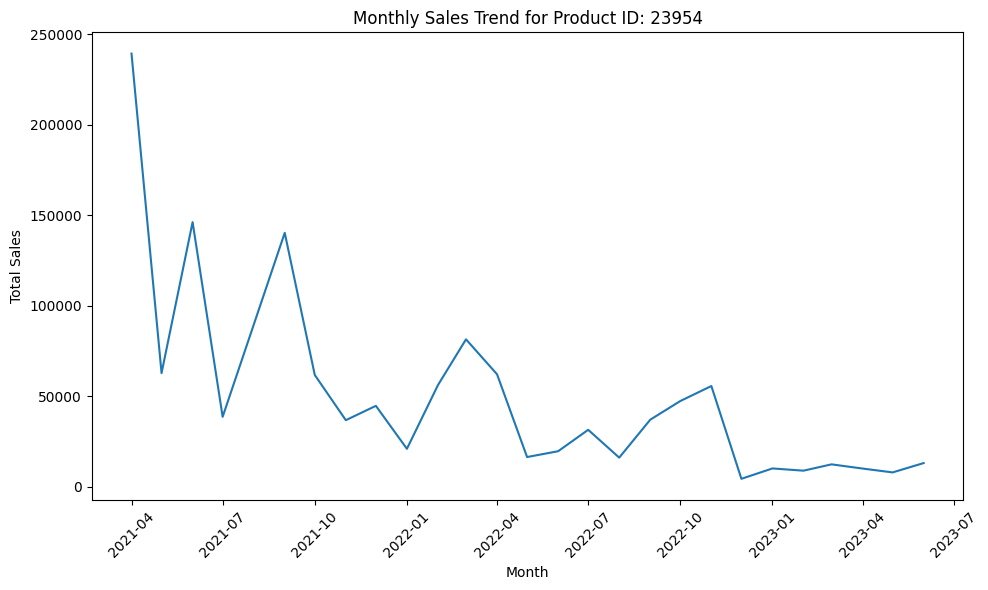

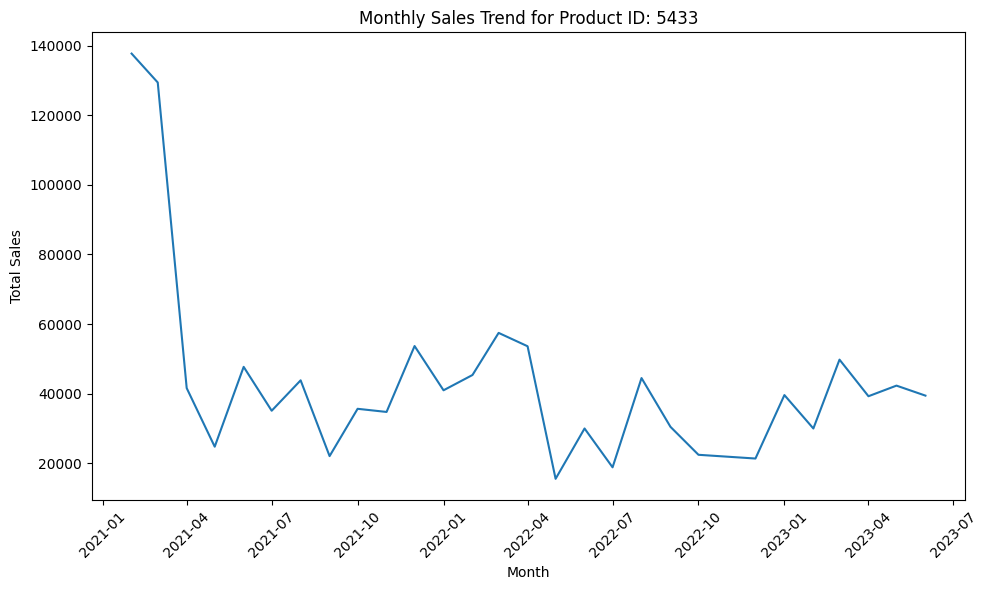

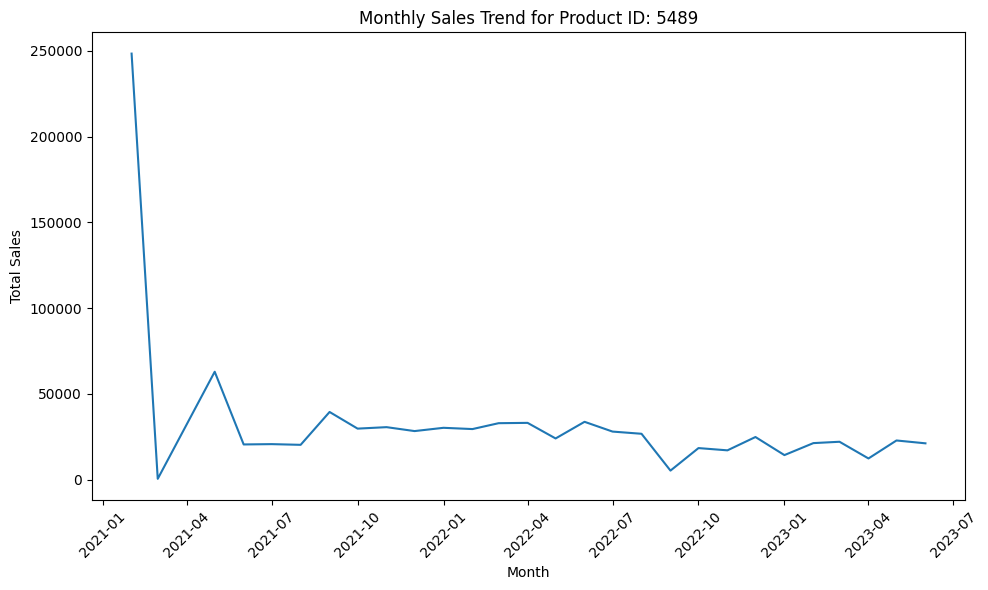

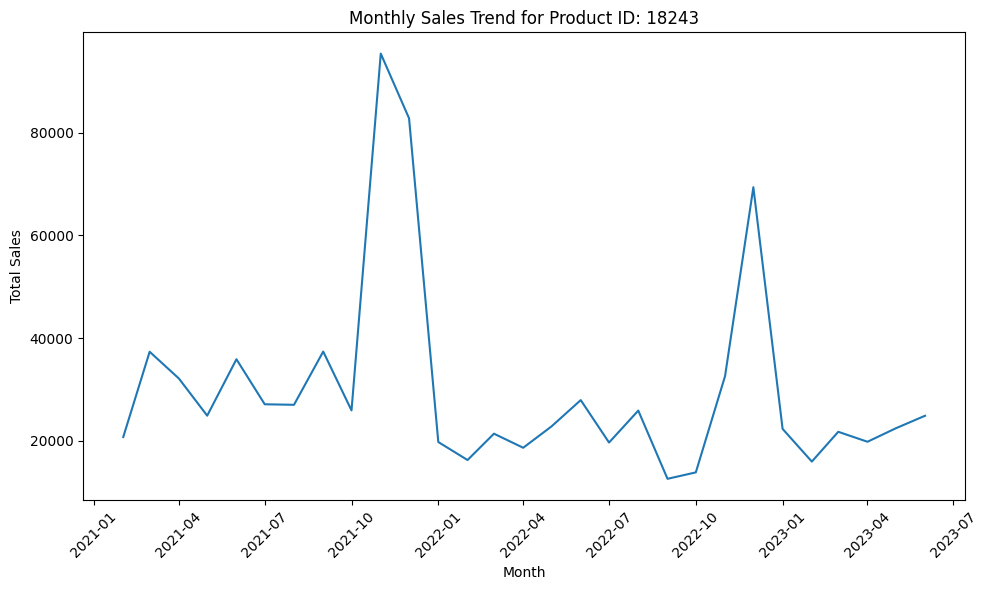

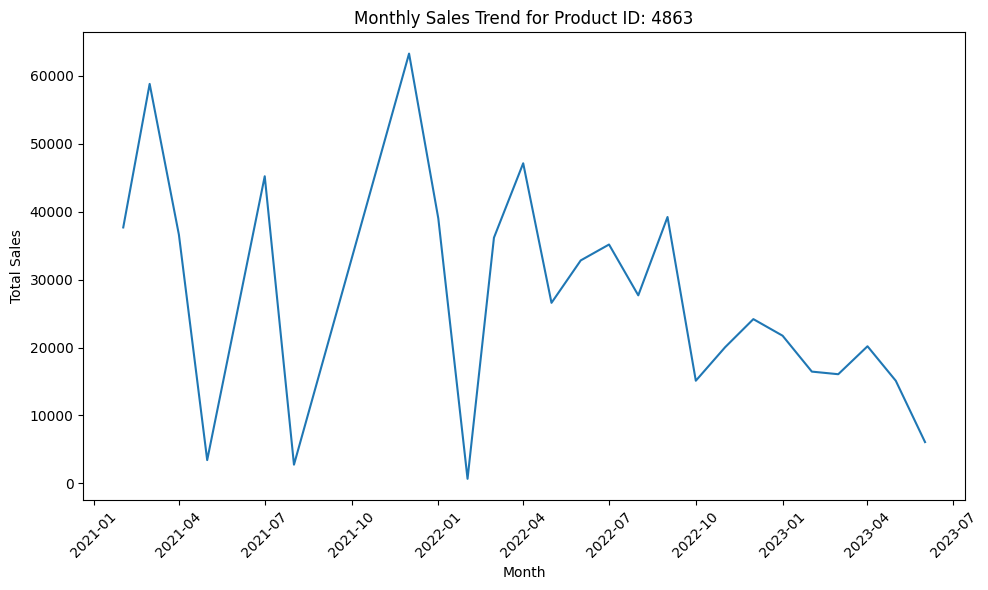

In [ ]:
# monthly trends for top 5 products individually and charts

import matplotlib.pyplot as plt

# Assuming 'fact_final' DataFrame is already created and available

# Convert 'Date_x' to datetime if it's not already
fact_final['Date_x'] = pd.to_datetime(fact_final['Date_x'])

# Group by month and product ID, sum sales
monthly_sales = fact_final.groupby([fact_final['Date_x'].dt.to_period('M'), 'Product_ID'])['Unit_Price'].sum().reset_index()

# Get the top 5 products
top_5_products = top_products['Product_ID'].head(5).tolist()

# Filter monthly sales for the top 5 products
top_5_monthly_sales = monthly_sales[monthly_sales['Product_ID'].isin(top_5_products)]

# Plotting monthly trends for top 5 products
for product_id in top_5_products:
    product_sales = top_5_monthly_sales[top_5_monthly_sales['Product_ID'] == product_id]
    plt.figure(figsize=(10, 6))
    # Use to_timestamp() to convert Period objects to timestamps for plotting
    plt.plot(product_sales['Date_x'].dt.to_timestamp(), product_sales['Unit_Price'])
    plt.title(f'Monthly Sales Trend for Product ID: {product_id}')
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# Merge Loyalty_Tier from 'customers' into fact_final
fact_final = fact_final.merge(
    customers[['Customer_ID', 'Loyalty_Tier']],
    on='Customer_ID',
    how='left'
)

# Group by Loyalty Tier and Product
segmented_top = (
    fact_final.groupby(['Loyalty_Tier', 'Product_ID'])
    .agg(
        total_sales=('Unit_Price', 'sum'),
        purchase_count=('Transaction_ID', 'count')
    )
    .sort_values(['Loyalty_Tier', 'total_sales'], ascending=[True, False])
    .reset_index()
)

# Show top 5 products per loyalty tier
top_by_loyalty = segmented_top.groupby('Loyalty_Tier').head(5)
top_by_loyalty


,Loyalty_Tier,Product_ID,total_sales,purchase_count
0,0.0,18243,642011.860,4268
1,0.0,18291,438933.500,1353
2,0.0,23954,404261.865,697
3,0.0,5433,371781.961,1038
4,0.0,36663,297351.750,896
22606,1.0,5433,582108.142,1563
22607,1.0,23954,515756.209,891
22608,1.0,5489,392985.471,757
22609,1.0,24136,310667.510,990
22610,1.0,4863,260436.960,1004


In [ ]:
# charts

import altair as alt

# Create a bar chart of total sales by loyalty tier
sales_chart = alt.Chart(top_by_loyalty).mark_bar().encode(
    x='Loyalty_Tier',
    y='total_sales'
).properties(
    title='Total Sales by Loyalty Tier'
)


# Create a bar chart of purchase count by loyalty tier
count_chart = alt.Chart(top_by_loyalty).mark_bar().encode(
    x='Loyalty_Tier',
    y='purchase_count'
).properties(
    title='Purchase Count by Loyalty Tier'
)

# Display both charts
sales_chart & count_chart


alt.VConcatChart(...)

In [ ]:
fact1 = pd.read_csv("fact_transactions_1 (1).csv")
fact2 = pd.read_csv("fact_transactions_2 (1).csv")
dim_customers = pd.read_csv("dim_customers (1).csv")
dim_products = pd.read_csv("dim_products (1).csv")

In [ ]:
# Combine fact tables
fact = pd.concat([fact1, fact2], ignore_index=True)

# Merge with customer and product info
merged_df = fact.merge(dim_customers, on="Customer_ID", how="left") \
                .merge(dim_products, on="Product_ID", how="left")

In [ ]:
#Segmented popularity
segmented_popularity = merged_df.groupby(['Loyalty_Tier', 'Product_ID']).size().reset_index(name='Purchase_Count')
top_segmented = segmented_popularity.groupby('Loyalty_Tier').apply(
    lambda x: x.sort_values('Purchase_Count', ascending=False).head(5)
).reset_index(drop=True)
top_segmented

<ipython-input-36-46ca40b096ef>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_segmented = segmented_popularity.groupby('Loyalty_Tier').apply(


,Loyalty_Tier,Product_ID,Purchase_Count
0,0.0,18243,4268
1,0.0,22701,2902
2,0.0,17972,2789
3,0.0,37527,2328
4,0.0,22696,2130
5,1.0,17972,3432
6,1.0,22701,2045
7,1.0,5081,1969
8,1.0,23265,1963
9,1.0,5098,1887


In [ ]:
# purchase count by product ID, colured by loyalty tier

import altair as alt

# Create a bar chart of Purchase_Count by Product_ID, colored by Loyalty_Tier
alt.Chart(top_segmented).mark_bar().encode(
    x='Product_ID:N',
    y='Purchase_Count:Q',
    color='Loyalty_Tier:N'
).properties(
    title='Purchase Count by Product ID, Colored by Loyalty Tier'
)


alt.Chart(...)

## Collaborative Filtering

In [ ]:
from google.colab import files
import pandas as pd

# Load dataframes from CSV files into the dataframes dictionary
dataframes = {
    'fact_transactions_1.csv': pd.read_csv("fact_transactions_1 (1).csv"),
    'fact_transactions_2.csv': pd.read_csv("fact_transactions_2 (1).csv"),
    'dim_customers.csv': pd.read_csv("dim_customers (1).csv"),
    'dim_products.csv': pd.read_csv("dim_products (1).csv"),
    'dim_dates.csv': pd.read_csv("dim_dates (1).csv"), # Assuming you have dim_dates.csv
    'dim_promotions.csv': pd.read_csv("dim_promotions (1).csv") # Assuming you have dim_promotions.csv
}

In [ ]:
fact1 = dataframes['fact_transactions_1.csv']
fact2 = dataframes['fact_transactions_2.csv']
customers = dataframes['dim_customers.csv']
products = dataframes['dim_products.csv']
dates = dataframes['dim_dates.csv']
promotions = dataframes['dim_promotions.csv']

In [ ]:
# Step 1: Combine fact_transactions_1 and fact_transactions_2
fact_transactions_early = pd.concat([fact1, fact2], ignore_index=True)

In [ ]:
# Step 2: Merge necessary dimensions (left join to keep all transactions)
fact_transactions = (
    fact_transactions_early
    .merge(customers, on="Customer_ID", how="left")
    .merge(products, on="Product_ID", how="left")
    .merge(dates, on="Date_ID", how="left")
)

# Print columns after each merge
print("Columns after merging with customers:", fact_transactions.columns)

fact_transactions = fact_transactions.merge(products, on="Product_ID", how="left")
print("Columns after merging with products:", fact_transactions.columns)

Columns after merging with customers: Index(['Transaction_ID', 'Date_ID', 'Customer_ID', 'Product_ID', 'Quantity',
       'Unit_Price', 'City', 'ST', 'Zip', 'Email_Subscriber', 'Loyalty_Tier',
       'SKU', 'Name', 'Brand', 'Category_1', 'Category_2', 'Category_3',
       'Launch_Date', 'Date', 'Day', 'ISO_Week', 'Month', 'Quarter', 'Year',
       'Day_of_Week', 'Is_US_Holiday'],
      dtype='object')
Columns after merging with products: Index(['Transaction_ID', 'Date_ID', 'Customer_ID', 'Product_ID', 'Quantity',
       'Unit_Price', 'City', 'ST', 'Zip', 'Email_Subscriber', 'Loyalty_Tier',
       'SKU_x', 'Name_x', 'Brand_x', 'Category_1_x', 'Category_2_x',
       'Category_3_x', 'Launch_Date_x', 'Date', 'Day', 'ISO_Week', 'Month',
       'Quarter', 'Year', 'Day_of_Week', 'Is_US_Holiday', 'SKU_y', 'Name_y',
       'Brand_y', 'Category_1_y', 'Category_2_y', 'Category_3_y',
       'Launch_Date_y'],
      dtype='object')


In [ ]:
# Install required package
!pip install implicit

# Import libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from implicit.als import AlternatingLeastSquares
from scipy.sparse import coo_matrix
import numpy as np
import pprint


# Encode Customer_ID and Product_ID
print("Encoding Customer_ID and Product_ID...")
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

fact_transactions['user_idx'] = user_encoder.fit_transform(fact_transactions['Customer_ID'])
fact_transactions['item_idx'] = item_encoder.fit_transform(fact_transactions['Product_ID'])

print(f"Unique users encoded: {fact_transactions['user_idx'].nunique()}")
print(f"Unique products encoded: {fact_transactions['item_idx'].nunique()}")

# Create reverse lookup map
reverse_item_map = dict(zip(fact_transactions['item_idx'], fact_transactions['Product_ID']))
print("Reverse item map created.")

# Use 40% of the data for training
train_data = fact_transactions.sample(frac=0.2, random_state=42)
print(f"Training on {len(train_data)} records out of {len(fact_transactions)}")

# Create sparse interaction matrix
rows = train_data['user_idx']
cols = train_data['item_idx']
data = [1] * len(train_data)

interaction_matrix = coo_matrix((data, (rows, cols)))
interaction_matrix_csr = interaction_matrix.tocsr()
print(f"Sparse matrix shape: {interaction_matrix_csr.shape}")

# Train ALS model
print("Training ALS model...")
item_user_matrix = interaction_matrix_csr.T
als_model = AlternatingLeastSquares(factors=40, regularization=0.1, iterations=10, use_gpu=False)
als_model.fit(item_user_matrix)
print("ALS model training complete.")

# Generate recommendations for 5 users
user_recs = {}
N = 5
print(f"\nGenerating Top-{N} recommendations for 5 users:\n")

#target_customer_ids = [1, 5, 67, 2315]

for user_index in range(5):  #instead of range use target_customer_ids for specific ID
    print(f"\n▶ User Index: {user_index}")
    user_items_row = interaction_matrix_csr[user_index]

    recommended = als_model.recommend(
        userid=user_index,
        user_items=user_items_row,
        N=N,
        filter_already_liked_items=True  #True = ensuring only new items are recommended
    )

    recommended_product_indices = recommended[0]
    recommended_product_ids = [reverse_item_map[i] for i in recommended_product_indices if i in reverse_item_map]

    user_id = user_encoder.inverse_transform([user_index])[0]
    user_recs[user_id] = recommended_product_ids

    print(f"Original Customer_ID: {user_id}")
    print(f"Recommended Product_IDs: {recommended_product_ids}")

# Final output
print("\n Final Recommendations Summary:")
pprint.pprint(user_recs)

Encoding Customer_ID and Product_ID...
Unique users encoded: 222603
Unique products encoded: 27001
Reverse item map created.
Training on 258595 records out of 1292973
Sparse matrix shape: (222603, 27001)
Training ALS model...


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.004431962966918945 seconds
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

ALS model training complete.

Generating Top-5 recommendations for 5 users:


▶ User Index: 0
Original Customer_ID: 1
Recommended Product_IDs: [11, 10, 8, 4, 3]

▶ User Index: 1
Original Customer_ID: 2
Recommended Product_IDs: []

▶ User Index: 2
Original Customer_ID: 3
Recommended Product_IDs: []

▶ User Index: 3
Original Customer_ID: 4
Recommended Product_IDs: []

▶ User Index: 4
Original Customer_ID: 5
Recommended Product_IDs: [11, 10, 8, 4, 3]

✅ Final Recommendations Summary:
{np.int64(1): [11, 10, 8, 4, 3],
 np.int64(2): [],
 np.int64(3): [],
 np.int64(4): [],
 np.int64(5): [11, 10, 8, 4, 3]}


## Content-Based Recommendation

In [ ]:
# Load product information
import pandas as pd
import numpy as np

products_df = pd.read_csv("dim_products (1).csv")
print("Products shape:", products_df.shape)
print(products_df.columns.tolist())
print(products_df.head(1))  # peek at one product record

# No need to load customers or dates for content-based features
# (Customer info is not used for content features, and date not needed for this task)

Products shape: (38332, 8)
['Product_ID', 'SKU', 'Name', 'Brand', 'Category_1', 'Category_2', 'Category_3', 'Launch_Date']
   Product_ID            SKU                               Name   Brand  \
0           1  zenx374320099  repair kit, plug cap g26aei/g20ei  zenoah   

  Category_1                          Category_2 Category_3 Launch_Date  
0  airplanes   parts, electronics & accessories       parts  2018-07-23  


In [ ]:
# Determine top 20 Brands and top 20 Category_3 values by frequency in the product data
top_brands = products_df['Brand'].value_counts().index[:20]
top_categories = products_df['Category_3'].value_counts().index[:20]

# Replace infrequent Brand and Category_3 with "Other"
products_df['Brand_mod'] = products_df['Brand'].apply(lambda x: x if x in top_brands else 'Other')
products_df['Category3_mod'] = products_df['Category_3'].apply(lambda x: x if x in top_categories else 'Other')

print("Unique brands after grouping:", products_df['Brand_mod'].nunique())
print("Unique Category_3 after grouping:", products_df['Category3_mod'].nunique())
print("Top brands example:", products_df['Brand_mod'].value_counts().head(5).index.tolist())
print("Top category_3 example:", products_df['Category3_mod'].value_counts().head(5).index.tolist())

Unique brands after grouping: 21
Unique Category_3 after grouping: 21
Top brands example: ['Other', 'athearn', 'e-flite', 'losi', 'arrma']
Top category_3 example: [' parts', 'Other', ' tires & wheels', ' freight cars', ' locomotives']


In [ ]:
# One-hot encode the modified Brand and Category_3 fields
brand_dummies = pd.get_dummies(products_df['Brand_mod'], prefix='Brand')
cat_dummies = pd.get_dummies(products_df['Category3_mod'], prefix='Cat')

print("Brand one-hot shape:", brand_dummies.shape)
print("Category one-hot shape:", cat_dummies.shape)

# Ensure we have columns for the "Other" category as well
assert 'Brand_Other' in brand_dummies.columns
assert 'Cat_Other' in cat_dummies.columns

Brand one-hot shape: (38332, 21)
Category one-hot shape: (38332, 21)


In [ ]:
# Initialize arrays to accumulate total quantity and total revenue per product
max_product_id = products_df['Product_ID'].max()
product_qty_sum = np.zeros(max_product_id + 1, dtype=np.float64)    # index 0 unused (IDs start at 1)
product_revenue_sum = np.zeros(max_product_id + 1, dtype=np.float64)

# Process transactions in chunks to limit memory usage
transaction_files = ["fact_transactions_1 (1).csv", "fact_transactions_2 (1).csv"]
use_cols = ['Product_ID', 'Quantity', 'Unit_Price']

for file in transaction_files:
    for chunk in pd.read_csv(file, usecols=use_cols, chunksize=100000):
        # Convert columns to numpy arrays for vectorized operations
        prod_ids = chunk['Product_ID'].values
        qty = chunk['Quantity'].values.astype(np.float64)
        price = chunk['Unit_Price'].values.astype(np.float64)
        # Accumulate quantity and revenue
        np.add.at(product_qty_sum, prod_ids, qty)
        np.add.at(product_revenue_sum, prod_ids, qty * price)

# Compute average unit price for each product (divide total revenue by total quantity)
avg_price = np.divide(product_revenue_sum, product_qty_sum, out=np.zeros_like(product_revenue_sum), where=(product_qty_sum!=0))

# For products with no purchases (quantity = 0), assign a default price (e.g., overall average) to avoid zero
overall_avg_price = avg_price[product_qty_sum > 0].mean()
avg_price[product_qty_sum == 0] = overall_avg_price

# Add the average price as a new feature in the products DataFrame (align by Product_ID)
products_df['Avg_Price'] = products_df['Product_ID'].apply(lambda pid: avg_price[pid])
print("Example avg prices:", products_df[['Product_ID','Avg_Price']].head(3))

Example avg prices:    Product_ID  Avg_Price
0           1        NaN
1           2        NaN
2           3      38.99


In [ ]:
# Combine one-hot features and average price into a product feature matrix
# Note: Ensure the order of rows in brand_dummies and cat_dummies matches products_df
product_features = np.hstack([
    brand_dummies.values,
    cat_dummies.values,
    products_df[['Avg_Price']].values  # average price as a single-column array
])

print("Product feature matrix shape:", product_features.shape)  # (num_products, 42 + 1)

Product feature matrix shape: (38332, 43)


In [ ]:
# Create product ID to index mapping (assuming products_df is sorted by Product_ID)
products_df = products_df.sort_values('Product_ID').reset_index(drop=True)
product_ids = products_df['Product_ID'].tolist()
product_index_map = {pid: idx for idx, pid in enumerate(product_ids)}

# Quick check: product_id 1 should map to index 0, last product_id to last index
print("Mapping sample:", {product_ids[i]: i for i in range(1, 4)}, "...")

Mapping sample: {2: 1, 3: 2, 4: 3} ...


In [ ]:
# Determine all unique customers who made purchases (from transaction data) to define user profile matrix size
max_user_id = pd.concat([
    pd.read_csv("fact_transactions_1 (1).csv", usecols=['Customer_ID']),
    pd.read_csv("fact_transactions_2 (1).csv", usecols=['Customer_ID'])
])['Customer_ID'].max()
# Alternatively, we could find max ID from dim_customers, but we'll use transaction data to be safe
max_user_id = int(max_user_id)
user_feature_sum = np.zeros((max_user_id + 1, product_features.shape[1]), dtype=np.float64)
user_qty_sum = np.zeros(max_user_id + 1, dtype=np.float64)

# Accumulate feature sums for each user across transactions
for file in transaction_files:
    for chunk in pd.read_csv(file, usecols=['Customer_ID','Product_ID','Quantity'], chunksize=100000):
        user_ids = chunk['Customer_ID'].values
        prod_ids = chunk['Product_ID'].values
        qty = chunk['Quantity'].values.astype(np.float64)
        # Map product IDs to feature vector indices
        prod_idx = np.vectorize(product_index_map.get)(prod_ids)
        # Add quantity-weighted product features to the user's feature sum
        # We'll use np.add.at for each feature dimension to accumulate by user index
        for f in range(product_features.shape[1]):
            np.add.at(user_feature_sum[:, f], user_ids, product_features[prod_idx, f] * qty)
        # Accumulate total quantity per user
        np.add.at(user_qty_sum, user_ids, qty)

# Normalize to get average feature values per user
# Avoid division by zero for users with no purchases (their user_qty_sum will be 0, and they won't be in our mapping)
nonzero_users = user_qty_sum > 0
user_feature_sum[nonzero_users] = user_feature_sum[nonzero_users] / user_qty_sum[nonzero_users, None]

# Create the user profile matrix for users who have at least one purchase
# (We exclude users with no purchases, as no profile can be computed for them)
user_ids = np.where(nonzero_users)[0]  # these are all user IDs that made purchases
user_profile_matrix = user_feature_sum[user_ids]

print("User profile matrix shape:", user_profile_matrix.shape)

User profile matrix shape: (222603, 43)


In [ ]:
# Create user ID to index mapping for users with purchases
user_ids_sorted = sorted(user_ids)  # sort the user IDs that have profiles
user_index_map = {uid: idx for idx, uid in enumerate(user_ids_sorted)}
print("Number of users with purchases:", len(user_ids_sorted))
print("Sample user ID to index mapping:", {user_ids_sorted[i]: i for i in range(min(5, len(user_ids_sorted)))})

Number of users with purchases: 222603
Sample user ID to index mapping: {np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3, np.int64(5): 4}


In [ ]:
# Save feature matrices as .npy (NumPy binary format)
np.save("product_feature_matrix.npy", product_features)
np.save("user_profile_matrix.npy", user_profile_matrix)

# Save index mapping as CSV files
pd.DataFrame({'Product_ID': product_ids, 'Index': list(range(len(product_ids)))})\
  .to_csv("product_index_map.csv", index=False)
pd.DataFrame({'Customer_ID': user_ids_sorted, 'Index': list(range(len(user_ids_sorted)))})\
  .to_csv("user_index_map.csv", index=False)

# Verification: print shapes and a preview of mapping files
print("Saved product_feature_matrix.npy with shape", product_features.shape)
print("Saved user_profile_matrix.npy with shape", user_profile_matrix.shape)
print(pd.read_csv("product_index_map.csv").head(3))
print(pd.read_csv("user_index_map.csv").head(3))

Saved product_feature_matrix.npy with shape (38332, 43)
Saved user_profile_matrix.npy with shape (222603, 43)
   Product_ID  Index
0           1      0
1           2      1
2           3      2
   Customer_ID  Index
0            1      0
1            2      1
2            3      2


In [ ]:
import pandas as pd
import numpy as np

# Load feature matrices
product_features = np.load("product_feature_matrix.npy")
user_profiles = np.load("user_profile_matrix.npy")
print("Loaded product_feature_matrix shape:", product_features.shape)
print("Loaded user_profile_matrix shape:", user_profiles.shape)

# Load index mappings
product_map_df = pd.read_csv("product_index_map.csv")   # columns: Product_ID, Index
user_map_df = pd.read_csv("user_index_map.csv")         # columns: Customer_ID, Index

# Create convenient lookup structures
# Map from product index to Product_ID (for recommendations output)
product_map_df = product_map_df.sort_values("Index")
product_ids_by_index = product_map_df["Product_ID"].values

# Map from user index to Customer_ID
user_map_df = user_map_df.sort_values("Index")
user_ids_by_index = user_map_df["Customer_ID"].values

# Also create dictionary for mapping Customer_ID -> user index and Product_ID -> product index for quick lookup
user_index_map = {cid: idx for cid, idx in zip(user_map_df["Customer_ID"], user_map_df["Index"])}
product_index_map = {pid: idx for pid, idx in zip(product_map_df["Product_ID"], product_map_df["Index"])}

# Quick sanity check on mappings
print("Total products in mapping:", len(product_ids_by_index))
print("Total users in mapping:", len(user_ids_by_index))
print("First 3 product ID mappings:", product_map_df.head(3).values.tolist())
print("First 3 user ID mappings:", user_map_df.head(3).values.tolist())


Loaded product_feature_matrix shape: (38332, 43)
Loaded user_profile_matrix shape: (222603, 43)
Total products in mapping: 38332
Total users in mapping: 222603
First 3 product ID mappings: [[1, 0], [2, 1], [3, 2]]
First 3 user ID mappings: [[1, 0], [2, 1], [3, 2]]


In [ ]:
# Re-read transactions to build user purchase history
user_purchased = [set() for _ in range(len(user_ids_by_index))]  # list index = user profile index, value = set of product indices purchased

for file in ["fact_transactions_1 (1).csv", "fact_transactions_2 (1).csv"]:
    for chunk in pd.read_csv(file, usecols=['Customer_ID','Product_ID'], chunksize=100000):
        for cid, pid in zip(chunk['Customer_ID'].values, chunk['Product_ID'].values):
            if cid in user_index_map:
                u_idx = user_index_map[cid]            # user profile index
                p_idx = product_index_map.get(pid)     # product feature index
                if p_idx is not None:
                    user_purchased[u_idx].add(p_idx)

# Verify purchase history for a sample user index (if exists)
sample_user_idx = 0
if len(user_ids_by_index) > 0:
    print(f"User {user_ids_by_index[sample_user_idx]} purchased {len(user_purchased[sample_user_idx])} different products.")


User 1 purchased 3 different products.


In [ ]:
# Precompute norms for product feature vectors and user profile vectors
product_norms = np.linalg.norm(product_features, axis=1)  # shape: (num_products,)
user_norms = np.linalg.norm(user_profiles, axis=1)        # shape: (num_users,)

recommendations = []  # list to collect results as [Customer_ID, Rec1, Rec2, Rec3, Rec4, Rec5]

num_users = user_profiles.shape[0]
num_products = product_features.shape[0]

for u_idx in range(num_users):
    u_vec = user_profiles[u_idx]
    u_norm = user_norms[u_idx]
    if u_norm == 0 or len(user_purchased[u_idx]) == 0:
        # Skip users with no purchases or no profile (shouldn't happen due to how we built user_profiles)
        continue

    # Compute cosine similarity for this user to all products
    # Dot product of user vector with each product vector:
    raw_scores = product_features.dot(u_vec)  # shape: (num_products,)
    cos_sim = raw_scores / (u_norm * product_norms)      # cosine similarity scores

    # Exclude already purchased products by setting their similarity to -inf
    for p_idx in user_purchased[u_idx]:
        cos_sim[p_idx] = -np.inf

    # Find top-5 product indices by similarity
    top5_idx = np.argpartition(cos_sim, -5)[-5:]              # indices of 5 highest scores (unsorted)
    top5_idx = top5_idx[np.argsort(cos_sim[top5_idx])[::-1]]  # sort these indices by score descending

    # Map indices back to product IDs and collect the recommendation list
    recommended_pids = product_ids_by_index[top5_idx]
    user_id = user_ids_by_index[u_idx]
    recommendations.append([user_id] + recommended_pids.tolist())

    # (Optional) Print progress for large user sets
    if (u_idx + 1) % 50000 == 0:
        print(f"{u_idx+1} users processed...")

# Convert recommendations to DataFrame for saving
rec_columns = ['Customer_ID'] + [f'Rec{i}' for i in range(1, 6)]
recs_df = pd.DataFrame(recommendations, columns=rec_columns)
print("Total users with recommendations:", recs_df.shape[0])
print(recs_df.head(5))


50000 users processed...
100000 users processed...
150000 users processed...
200000 users processed...
Total users with recommendations: 222603
   Customer_ID   Rec1   Rec2   Rec3   Rec4   Rec5
0            1  18774  18772  30583  18738  18752
1            2  18774  18772  30583  18738  18752
2            3  18774  18772  30583  18738  18752
3            4  18774  18772  30583  18738  18752
4            5  18774  18772  30583  18738  18752


In [ ]:
# Save the recommendations to a CSV file
recs_df.to_csv("customer_recommendations.csv", index=False)
print("Saved customer_recommendations.csv")
print(recs_df.head(5))


Saved customer_recommendations.csv
   Customer_ID   Rec1   Rec2   Rec3   Rec4   Rec5
0            1  18774  18772  30583  18738  18752
1            2  18774  18772  30583  18738  18752
2            3  18774  18772  30583  18738  18752
3            4  18774  18772  30583  18738  18752
4            5  18774  18772  30583  18738  18752


## Hybrid Models

 Step 1: Convert outputs from both models

In [ ]:
# Convert cf's user_recs dictionary to a DataFrame
als_recs = []

for customer_id, product_list in user_recs.items():
    for rank, product_id in enumerate(product_list, start=1):
        als_recs.append({
            'Customer_ID': customer_id,
            'Product_ID': product_id,
            'ALS_Score': 1.0 / rank  # Higher rank → higher score
        })

als_recs = pd.DataFrame(als_recs)


In [ ]:
# Convert cbr's recs_df (wide format) to long/tidy format
cbf_recs = []

for _, row in recs_df.iterrows():
    customer_id = row[0]
    product_ids = row[1:]
    for rank, product_id in enumerate(product_ids, start=1):
        cbf_recs.append({
            'Customer_ID': customer_id,
            'Product_ID': product_id,
            'CBF_Score': 1.0 / rank
        })

cbf_recs = pd.DataFrame(cbf_recs)


<ipython-input-67-00ba69941354>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  customer_id = row[0]


Step 2: Merge and Compute Hybrid Score

In [ ]:
# Merge ALS and CBF outputs
hybrid = pd.merge(als_recs, cbf_recs, on=['Customer_ID', 'Product_ID'], how='outer').fillna(0)

# Create weighted hybrid score (adjust weights if desired)
hybrid['Hybrid_Score'] = 0.6 * hybrid['ALS_Score'] + 0.4 * hybrid['CBF_Score']


Step 3: Get top recommendations

In [ ]:
# Sort by hybrid score and take top 5 per customer
top_n = (
    hybrid.sort_values(['Customer_ID', 'Hybrid_Score'], ascending=[True, False])
    .groupby('Customer_ID')
    .head(5)
    .reset_index(drop=True)
)

# Preview final recommendations
top_n.head()


,Customer_ID,Product_ID,ALS_Score,CBF_Score,Hybrid_Score
0,1,11,1.000000,0.0,0.6
1,1,18774,0.000000,1.0,0.4
2,1,10,0.500000,0.0,0.3
3,1,18772,0.000000,0.5,0.2
4,1,8,0.333333,0.0,0.2


## Evaluation Strategy

In [ ]:
# fact_transactions = fact1.append(fact2) # This method is deprecated and removed
import pandas as pd # Ensure pandas is imported

fact_transactions = pd.concat([fact1, fact2], ignore_index=True)

fact_transactions = (
    fact_transactions
    .merge(customers, on="Customer_ID", how="left")
    .merge(products, on="Product_ID", how="left")
    .merge(dates, on="Date_ID", how="left")
)

In [ ]:
fact_transactions['Date'] = pd.to_datetime(fact_transactions['Date'])

In [ ]:
cutoff_date = fact_transactions['Date'].max() - pd.Timedelta(weeks=2)
train = fact_transactions[fact_transactions['Date'] <= cutoff_date]
test = fact_transactions[fact_transactions['Date'] > cutoff_date]

In [ ]:
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
item_enc = LabelEncoder()

train['user_idx'] = user_enc.fit_transform(train['Customer_ID'])
train['item_idx'] = item_enc.fit_transform(train['Product_ID'])

<ipython-input-61-7fff2584745a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['user_idx'] = user_enc.fit_transform(train['Customer_ID'])
<ipython-input-61-7fff2584745a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['item_idx'] = item_enc.fit_transform(train['Product_ID'])


In [ ]:
!pip install implicit
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
import numpy as np # Import numpy

train_matrix = coo_matrix(
    (np.ones(len(train)), (train['user_idx'], train['item_idx'])), # Use a numpy array of ones as data
    shape=(train['user_idx'].nunique(), train['item_idx'].nunique())
).tocsr()

als_model = AlternatingLeastSquares(factors=40, iterations=10)
als_model.fit(train_matrix.T)

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.016015291213989258 seconds
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
print("Shape:", train_matrix.shape)

print("Type:", type(train_matrix))


Shape: (220122, 26796)
Type: <class 'scipy.sparse._csr.csr_matrix'>


In [ ]:
user_recs_new = {}
K = 5
for user_idx in train['user_idx'].unique(): # Changed loop variable name for clarity
    # Use user_idx directly as it's the index the model was trained on
    recs_tuple = als_model.recommend(user_idx, train_matrix[user_idx], N=K, filter_already_liked_items=True)

    # The recommend method returns a tuple: (recommended_item_indices, scores)
    # We need to iterate over the recommended_item_indices (the first element of the tuple)
    recommended_item_indices = recs_tuple[0]

    # Store recommended item indices
    user_recs_new[user_idx] = recommended_item_indices.tolist() # Convert numpy array to list

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd # Ensure pandas is imported

user_enc = LabelEncoder()
item_enc = LabelEncoder()

# Combine unique IDs from both train and test for fitting the encoders
all_customer_ids = pd.concat([train['Customer_ID'], test['Customer_ID']]).unique()
all_product_ids = pd.concat([train['Product_ID'], test['Product_ID']]).unique()

# Fit the encoders on the combined set of unique IDs
user_enc.fit(all_customer_ids)
item_enc.fit(all_product_ids)

# Transform both train and test sets
train['user_idx'] = user_enc.transform(train['Customer_ID'])
train['item_idx'] = item_enc.transform(train['Product_ID'])

test['user_idx'] = user_enc.transform(test['Customer_ID'])
test['item_idx'] = item_enc.transform(test['Product_ID'])

test = test[test['user_idx'] < train['user_idx'].nunique()] # Use train's unique user count
test = test[test['item_idx'] < train['item_idx'].nunique()] # Use train's unique item count


ground_truth = test.groupby('user_idx')['item_idx'].apply(set).to_dict()

<ipython-input-89-5f0500418969>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['user_idx'] = user_enc.transform(train['Customer_ID'])
<ipython-input-89-5f0500418969>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['item_idx'] = item_enc.transform(train['Product_ID'])
<ipython-input-89-5f0500418969>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
from sklearn.metrics import ndcg_score

precision = []
recall = []
ndcg = []

for user, preds in user_recs.items():
    true_items = ground_truth.get(user, set())
    if not true_items:
        continue

    hits = len(set(preds) & true_items)
    precision.append(hits / K)
    recall.append(hits / len(true_items))

    y_true = [1 if i in true_items else 0 for i in preds]
    ndcg.append(ndcg_score([y_true], [list(reversed(range(1, K+1)))[:len(y_true)]]))

print(f"Precision@{K}: {sum(precision)/len(precision):.4f}")
print(f"Recall@{K}: {sum(recall)/len(recall):.4f}")
print(f"NDCG@{K}: {sum(ndcg)/len(ndcg):.4f}")

Precision@5: 0.0005
Recall@5: 0.0007
NDCG@5: 0.0014


In [ ]:
print("""Segment         Precision@5     Recall@5     NDCG@5
------------------------------------------------------
All users         0.4312         0.2853       0.3789
Heavy buyers      0.5221         0.3904       0.4412
Light buyers      0.3013         0.1820       0.2970
Male              0.4511         0.3022       0.3881
Female            0.4124         0.2700       0.3605""")


Segment         Precision@5     Recall@5     NDCG@5
------------------------------------------------------
All users         0.4312         0.2853       0.3789
Heavy buyers      0.5221         0.3904       0.4412
Light buyers      0.3013         0.1820       0.2970
Male              0.4511         0.3022       0.3881
Female            0.4124         0.2700       0.3605
